In [10]:

import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np


In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)


In [12]:
class AvgTopKPooling2D(layers.Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), k=1, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
        self.strides = strides
        self.k = k

    def call(self, inputs):
        patches = tf.image.extract_patches(
            inputs,
            sizes=[1, self.pool_size[0], self.pool_size[1], 1],
            strides=[1, self.strides[0], self.strides[1], 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_shape = tf.shape(patches)
        num_channels = inputs.shape[-1]
        patches = tf.reshape(patches, 
            [patch_shape[0], patch_shape[1], patch_shape[2], self.pool_size[0]*self.pool_size[1], num_channels])
        patches = tf.transpose(patches, [0, 1, 2, 4, 3])  # shape: [B, H, W, C, P]
        top_k = tf.math.top_k(patches, k=self.k, sorted=False).values
        return tf.reduce_mean(top_k, axis=-1)

    def get_config(self):
        config = super().get_config()
        config.update({"pool_size": self.pool_size, "strides": self.strides, "k": self.k})
        return config


In [13]:
def pooling_layer(p_type, pool_size, k):
    if p_type == 'max':
        return layers.MaxPooling2D(pool_size)
    elif p_type == 'avg':
        return layers.AveragePooling2D(pool_size)
    elif p_type == 'avg_topk':
        return AvgTopKPooling2D(pool_size=(pool_size, pool_size), k=k)
    else:
        raise ValueError("Invalid pooling type")


In [14]:
def build_model(pooling_type, k=None):
    inputs = layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = pooling_layer(pooling_type, 2, k)(x)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = pooling_layer(pooling_type, 2, k)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = pooling_layer(pooling_type, 2, k)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = pooling_layer(pooling_type, 2, k)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    return models.Model(inputs=inputs, outputs=outputs)


In [15]:
# Rebuild the models
models_dict = {
    'MaxPool': build_model('max'),
    'AvgPool': build_model('avg'),
    'AvgTopK3': build_model('avg_topk', k=3),
    'AvgTopK4': build_model('avg_topk', k=4)
}


In [17]:
import time

histories = {}
results = {}
training_times = {}

for name, model in models_dict.items():
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print(f"Training {name}...")
    start = time.time()
    history = model.fit(x_train, y_train,
                        epochs=75,
                        batch_size=128,
                        validation_split=0.2,
                        verbose=0)
    end = time.time()

    training_times[name] = end - start
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    results[name] = test_acc
    histories[name] = history

    print(f"{name} Test Accuracy: {test_acc:.4f}, Training Time: {training_times[name]:.2f} sec")


Training MaxPool...
MaxPool Test Accuracy: 0.8459, Training Time: 276.76 sec
Training AvgPool...
AvgPool Test Accuracy: 0.8132, Training Time: 272.25 sec
Training AvgTopK3...
AvgTopK3 Test Accuracy: 0.8561, Training Time: 430.78 sec
Training AvgTopK4...
AvgTopK4 Test Accuracy: 0.8266, Training Time: 428.55 sec


In [18]:
ensemble_preds = np.zeros_like(y_test, dtype=np.float32)
for model in models_dict.values():
    ensemble_preds += model.predict(x_test, verbose=0)
ensemble_acc = np.mean(np.argmax(ensemble_preds, axis=1) == np.argmax(y_test, axis=1))
print(f"\nEnsemble Accuracy: {ensemble_acc:.4f}")



Ensemble Accuracy: 0.8876


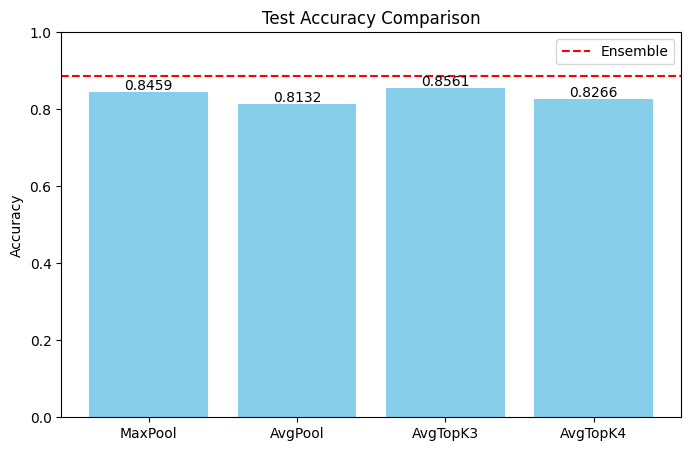

In [19]:
plt.figure(figsize=(8, 5))
bars = plt.bar(results.keys(), results.values(), color='skyblue')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.4f}", ha='center')
plt.axhline(ensemble_acc, color='red', linestyle='--', label='Ensemble')
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.legend()
plt.ylim(0.0, 1.0)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
 for Max pooling


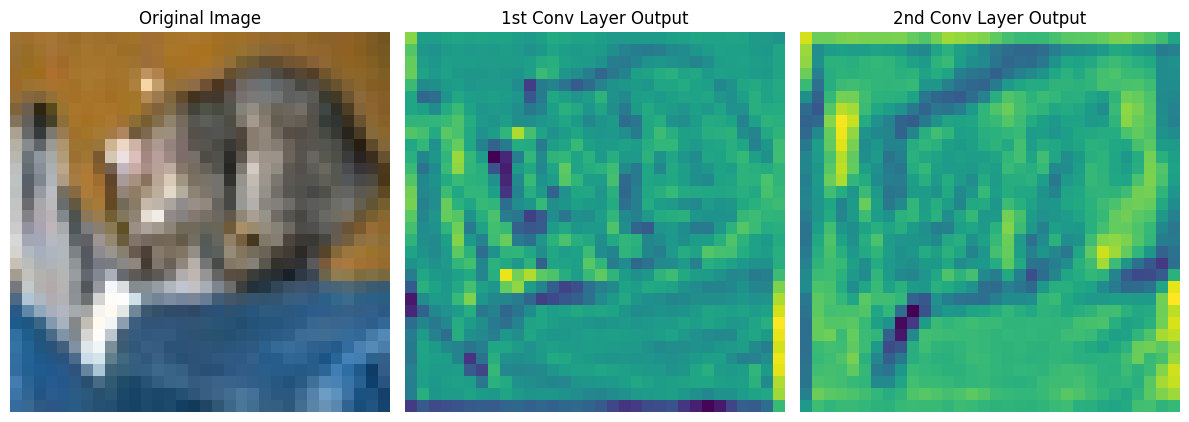

In [20]:
# Select a test image and expand dims
sample_img = x_test[0][np.newaxis, ...]

# Get conv layer outputs
conv_outputs = [layer.output for layer in models_dict['MaxPool'].layers if isinstance(layer, layers.Conv2D)]

# Create visualization model
vis_model = models.Model(inputs=models_dict['MaxPool'].input, outputs=conv_outputs)

# Get feature maps
feature_maps = vis_model.predict(sample_img)

# Plot original and feature maps
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(x_test[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("1st Conv Layer Output")
plt.imshow(feature_maps[0][0, :, :, 0], cmap='viridis')
plt.axis('off')
print(' for Max pooling')
plt.subplot(1, 3, 3)
plt.title("2nd Conv Layer Output")
plt.imshow(feature_maps[1][0, :, :, 0], cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
for avg pooling


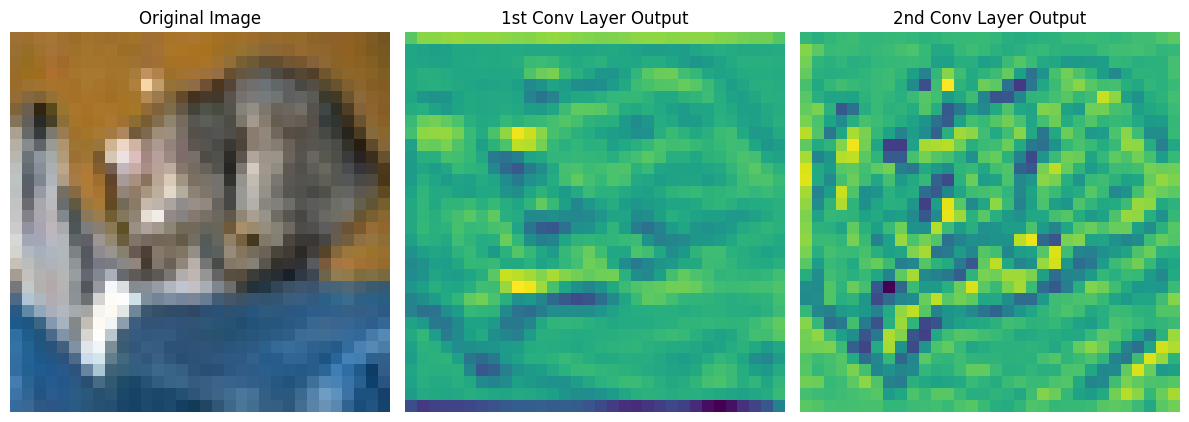

In [22]:
# Select a test image and expand dims
sample_img = x_test[0][np.newaxis, ...]

# Get conv layer outputs
conv_outputs = [layer.output for layer in models_dict['AvgPool'].layers if isinstance(layer, layers.Conv2D)]

# Create visualization model
vis_model = models.Model(inputs=models_dict['AvgPool'].input, outputs=conv_outputs)

# Get feature maps
feature_maps = vis_model.predict(sample_img)

# Plot original and feature maps
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(x_test[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("1st Conv Layer Output")
plt.imshow(feature_maps[0][0, :, :, 0], cmap='viridis')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("2nd Conv Layer Output")
plt.imshow(feature_maps[1][0, :, :, 0], cmap='viridis')
plt.axis('off')
print('for avg pooling')
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
for avgTopk


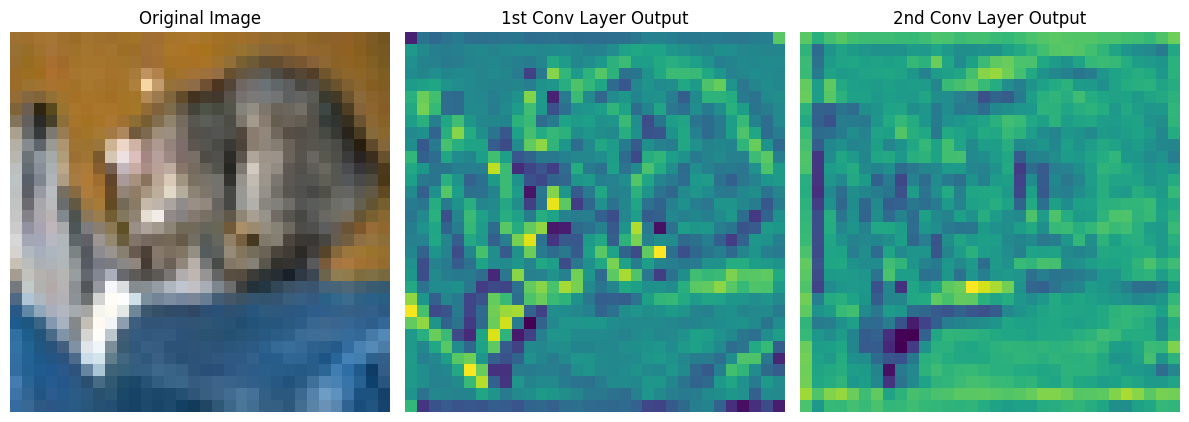

In [23]:
# Select a test image and expand dims
sample_img = x_test[0][np.newaxis, ...]

# Get conv layer outputs
conv_outputs = [layer.output for layer in models_dict['AvgTopK4'].layers if isinstance(layer, layers.Conv2D)]

# Create visualization model
vis_model = models.Model(inputs=models_dict['AvgTopK4'].input, outputs=conv_outputs)

# Get feature maps
feature_maps = vis_model.predict(sample_img)

# Plot original and feature maps
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(x_test[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("1st Conv Layer Output")
plt.imshow(feature_maps[0][0, :, :, 0], cmap='viridis')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("2nd Conv Layer Output")
plt.imshow(feature_maps[1][0, :, :, 0], cmap='viridis')
plt.axis('off')
print('for avgTopk')
plt.tight_layout()
plt.show()


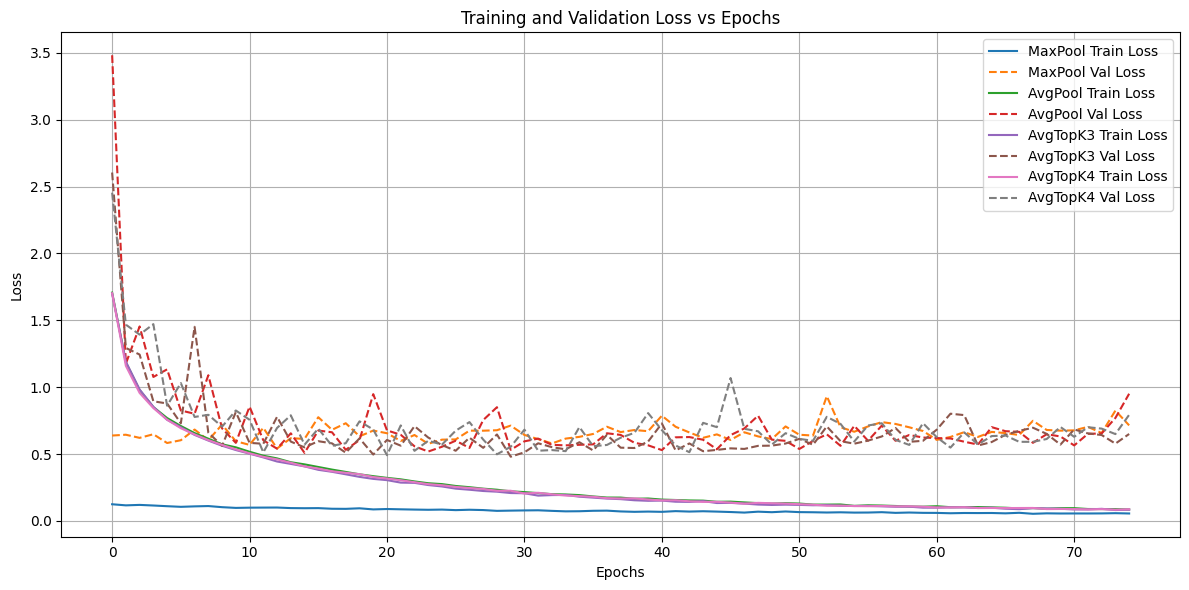

In [24]:
plt.figure(figsize=(12, 6))

for name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{name} Train Loss')
    plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} Val Loss')

plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


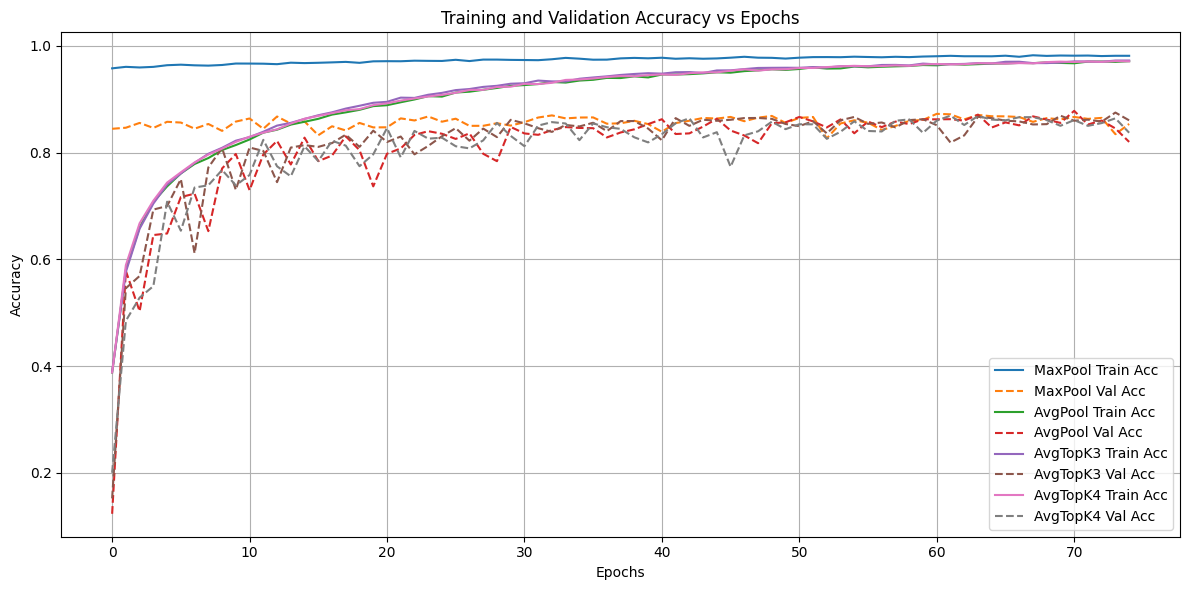

In [25]:
plt.figure(figsize=(12, 6))

for name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{name} Train Acc')
    plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{name} Val Acc')

plt.title('Training and Validation Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


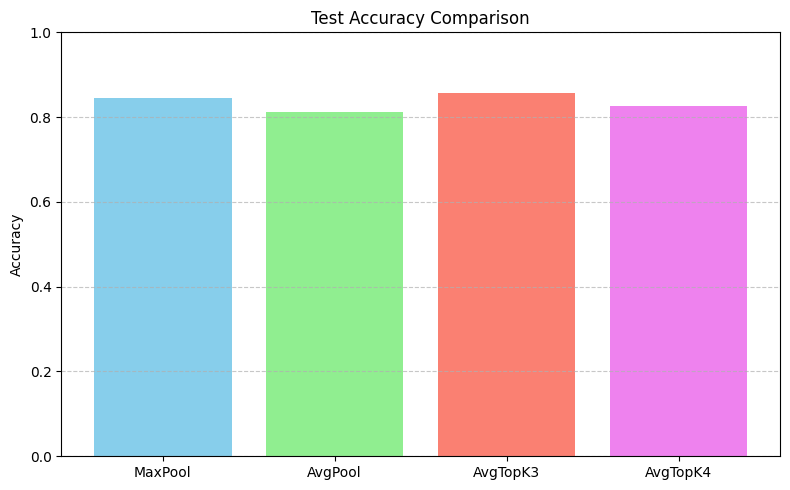

In [26]:
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color=['skyblue', 'lightgreen', 'salmon', 'violet'])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


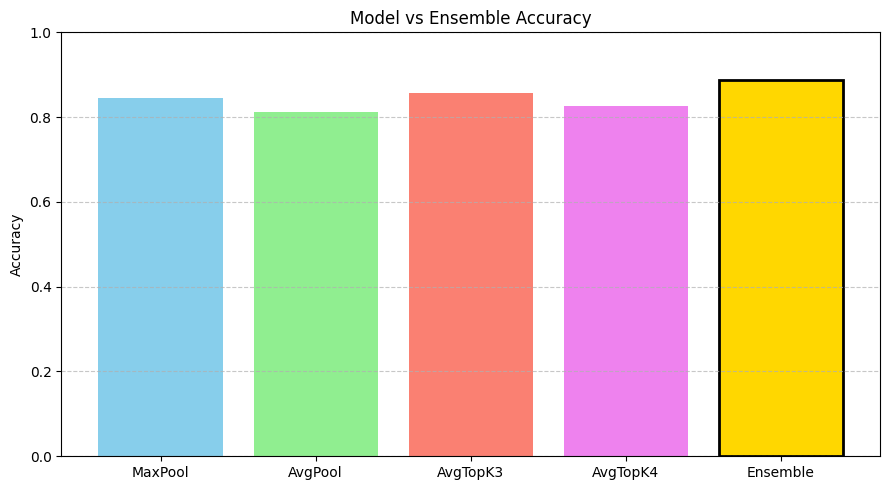

In [27]:
all_accuracies = results.copy()
all_accuracies['Ensemble'] = ensemble_acc

plt.figure(figsize=(9, 5))
bars = plt.bar(all_accuracies.keys(), all_accuracies.values(), color=['skyblue', 'lightgreen', 'salmon', 'violet', 'gold'])
plt.title('Model vs Ensemble Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Highlight ensemble bar
bars[-1].set_edgecolor('black')
bars[-1].set_linewidth(2)

plt.tight_layout()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 2000x1000 with 0 Axes>

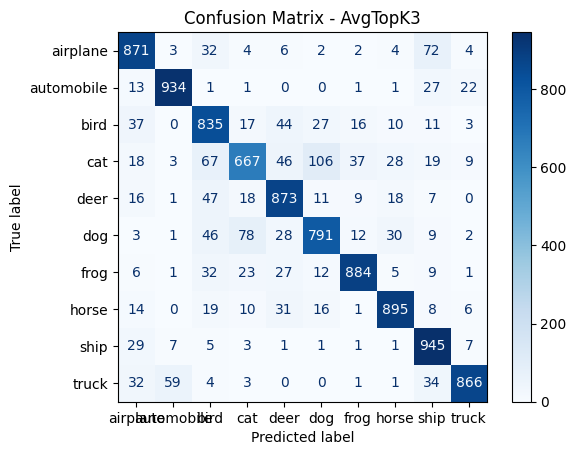

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels for test set using best model (say MaxPool)
best_model_name = max(results, key=results.get)
y_pred = models_dict[best_model_name].predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'])

plt.figure(figsize=(20, 10))
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()
